# **Описание проекта: промышленность**

**ТЗ**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).


**Шаги реализации проекта:**

- Загрузить данные
- Предобработать и исследовать данные
- Подготовить данные к обучению
- Протестировать различные модели
- Выбрать и протестировать лучшую модель
- Сформулировать общий вывод работы

**Таргет**

- Таргет нужно вывести самостоятельно
- Ключевой метрикой взята MAE, которая должна быть не больше 6.8
- Удалить признаки, где больше 80% пропусков
- Удалить ключи с 1 замером температуры
- Удалить значения с температурой меньше 1500

In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import math
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

import shap

In [3]:
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

RS = 111223

**Загрузка данных**

In [4]:
df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

In [5]:
df_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk_new.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [6]:
df_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_bulk_time_new.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

In [7]:
df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [8]:
df_temp = pd.read_csv('/datasets/data_temp_new.csv')
df_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

In [9]:
df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [10]:
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
df_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

Данные с процентным соотношением пропусков нам вероятно пригодятся позже

In [11]:
missing_values = df_wire.isnull().sum()
total_values = df_wire.shape[0]
percentage_missing = (missing_values / total_values) * 100
missing_data = pd.DataFrame({'Количество пропусков': missing_values, 'Процент пропусков': percentage_missing})
missing_data

Количество пропусков  Процент пропусков
key                        0           0.000000
Wire 1                    26           0.843882
Wire 2                  2002          64.978903
Wire 3                  3018          97.955209
Wire 4                  3067          99.545602
Wire 5                  3080          99.967543
Wire 6                  3008          97.630639
Wire 7                  3070          99.642973
Wire 8                  3062          99.383317
Wire 9                  3052          99.058747

In [12]:
missing_values_ = df_bulk_new.isnull().sum()
total_values_ = df_bulk_new.shape[0]
percentage_missing_ = (missing_values_ / total_values_) * 100
missing_data_ = pd.DataFrame({'Количество пропусков': missing_values_, 'Процент пропусков': percentage_missing_})
missing_data_

Количество пропусков  Процент пропусков
key                         0           0.000000
Bulk 1                   2877          91.946309
Bulk 2                   3107          99.296900
Bulk 3                   1831          58.517098
Bulk 4                   2115          67.593480
Bulk 5                   3052          97.539150
Bulk 6                   2553          81.591563
Bulk 7                   3104          99.201023
Bulk 8                   3128          99.968041
Bulk 9                   3110          99.392777
Bulk 10                  2953          94.375200
Bulk 11                  2952          94.343241
Bulk 12                   679          21.700224
Bulk 13                  3111          99.424736
Bulk 14                   323          10.322787
Bulk 15                   881          28.155960

## Предобработка данных

### Приведение названий полей к нормальному виду

In [13]:
def lowercase_and_replace_spaces(df):
    cols_list = [col.lower().replace(' ', '_') for col in df.columns]
    cols = dict(zip(df.columns, cols_list))
    df.rename(columns=cols, inplace=True)
    return df

In [14]:
compiled_data = [df_arc, df_bulk_new, df_bulk_time_new, df_gas, df_temp, df_wire, df_wire_time]

In [15]:
for df in compiled_data:
    df = lowercase_and_replace_spaces(df)

In [16]:
for i, df in enumerate(compiled_data):
    print(f"DataFrame {i + 1}:")
    print(df.head())
    print("\n")

DataFrame 1:
   key начало_нагрева_дугой  конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  


DataFrame 2:
   key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN   

In [17]:
cols_arc = {
    'начало_нагрева_дугой':'arc_heating_start',
    'конец_нагрева_дугой':'arc_heating_finish',
    'активная_мощность':'active_power',
    'реактивная_мощность':'reactive_power'
}

cols_gas = {
    'газ_1':'gas_1'
}

cols_temp = {
    'время_замера':'measure_time',
    'температура':'temperature'
}

In [18]:
df_arc = df_arc.rename(columns=cols_arc)
df_gas = df_gas.rename(columns=cols_gas)
df_temp = df_temp.rename(columns=cols_temp)

In [19]:
for i in [df_arc, df_gas, df_temp]:
    print(i.head())

   key    arc_heating_start   arc_heating_finish  active_power  reactive_power
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.305130        0.211253
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.765658        0.477438
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36      0.580313        0.430460
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19      0.518496        0.379979
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37      0.867133        0.643691
   key      gas_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
   key         measure_time  temperature
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0


### Обработка пропусков

In [20]:
for df in compiled_data:
    print(df.shape)

(14876, 5)
(3129, 16)
(3129, 16)
(3239, 2)
(18092, 3)
(3081, 10)
(3081, 10)


In [21]:
for df in compiled_data:
    print(df.isna().sum())

key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
key      0
газ_1    0
dtype: int64
key                0
время_замера       0
температура     3427
dtype: int64
key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64
key          0
wire_1      26
wire_2    2002


На созвоне с заказчиком мы выяснили, что пропуски в данных – это отсутствие материалов, поэтому их можно заполнить нулями

Таблицы со временем (bulk_time, wire_time) не входят в финальный датасет

In [22]:
df_wire = df_wire.fillna(0)
df_bulk_new = df_bulk_new.fillna(0)

Из таблицы с температурой удалим значения с пропусками, так как 
1) Их количество не является весомым для данных (3427 из 18092)
2) Любые заполнения могут ухудшить качество модели

In [23]:
df_temp.dropna(inplace=True)

In [24]:
df_temp.isna().sum()

key             0
measure_time    0
temperature     0
dtype: int64

In [25]:
df_temp.shape

(14665, 3)

In [26]:
for i in [df_arc, df_gas, df_bulk_new, df_wire, df_temp]:
    print(i.isna().sum())

key                   0
arc_heating_start     0
arc_heating_finish    0
active_power          0
reactive_power        0
dtype: int64
key      0
gas_1    0
dtype: int64
key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64
key             0
measure_time    0
temperature     0
dtype: int64


In [27]:
# Проверим типы данных у полей

# Этот массив повторяется, чтобы в него сохранились уже обработанные датафреймы
compiled_data = [df_arc, df_bulk_new, df_bulk_time_new, df_gas, df_temp, df_wire, df_wire_time]

for df in compiled_data:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 14876 non-null  int64  
 1   arc_heating_start   14876 non-null  object 
 2   arc_heating_finish  14876 non-null  object 
 3   active_power        14876 non-null  float64
 4   reactive_power      14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   f

Все временные данные нужно привести к типу DateTime. Хоть мы и определили, что они не войдут в итоговый датасет, они могут быть полезны в анализе

In [28]:
df_temp['measure_time'] = pd.to_datetime(df_temp['measure_time'], 
                                         format='%Y-%m-%d %H:%M:%S')

df_arc['arc_heating_start'] = pd.to_datetime(df_arc['arc_heating_start'], 
                                             format='%Y-%m-%d %H:%M:%S')
df_arc['arc_heating_finish'] = pd.to_datetime(df_arc['arc_heating_finish'], 
                                              format='%Y-%m-%d %H:%M:%S')

In [29]:
for i in df_wire_time.columns:
    df_wire_time[i] = pd.to_datetime(df_wire_time[i], 
                                     format='%Y-%m-%d %H:%M:%S')
    
for i in df_bulk_time_new.columns:
    df_bulk_time_new[i] = pd.to_datetime(df_bulk_time_new[i], 
                                     format='%Y-%m-%d %H:%M:%S')

In [30]:
compiled_data = [df_arc, df_bulk_new, df_bulk_time_new, df_gas, df_temp, df_wire, df_wire_time]

for df in compiled_data:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   arc_heating_start   14876 non-null  datetime64[ns]
 2   arc_heating_finish  14876 non-null  datetime64[ns]
 3   active_power        14876 non-null  float64       
 4   reactive_power      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6  

Теперь все типы данных в порядке в порядке

In [31]:
df_arc = df_arc.loc[df_arc['reactive_power'] > 0]
df_arc.shape

(14875, 5)

### Поиск дубликатов

In [32]:
for i in compiled_data:
    print(i.duplicated().sum())

0
0
0
0
0
0
0


**Вывод по предобработке**

- Были получены данные из 7 таблиц
- В данных были пропуски: пропуски по материалам были заполнены нулями6 так как означали отсутствие материала, пропуски по температуре были удалены
- Таблицы с временными полями были оставлены для анализа, но в общий датасет они не пойдут
- Все временные поля были типа Object, но приведены к типу DateTime
- Явных дубликатов не было обнаружено. Неявняые нет смысла искать, так как нет категориальных признаков, где может, к примеру, отличаться написание отдного и того же слова. По сути, мы имеем множество значений Float

## EDA

In [33]:
def distribution(df=None, field=None):
    try:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df[field], kde=True, alpha=0.5)
        plt.title(f'Распределение по {field}')
        plt.xlabel(f'{field}')
        plt.ylabel('Величина')
        plt.show()
        
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df[field])
        plt.title(f'Boxplot по {field}')
        plt.xlabel(f'{field}')
        plt.ylabel('Величина')
        plt.show()
    except:
        print('Что-то с полем или датафреймом')

### df_arc EDA

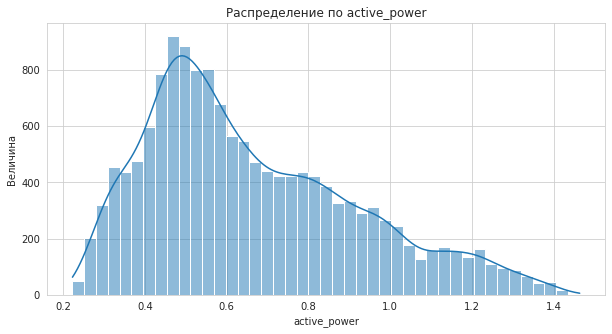

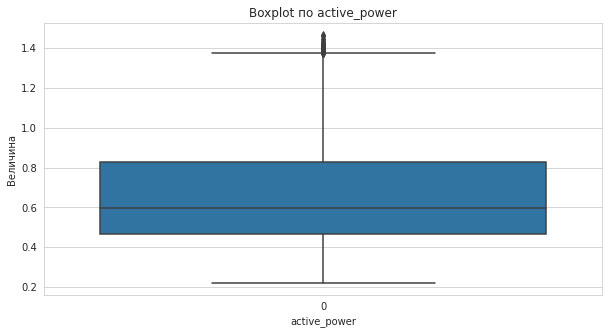

In [34]:
distribution(df_arc, 'active_power')

**Вывод по Arc**

Медианная мощность 0.6 у.о. Размах мощности от 0.2 до 1.5

### df_wire EDA

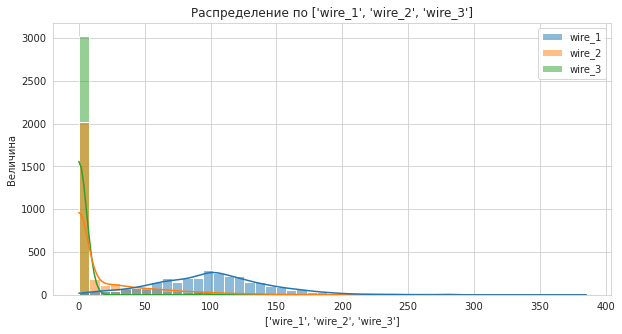

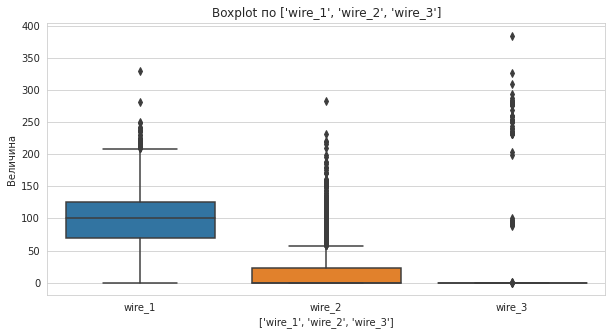

In [35]:
distribution(df_wire, ['wire_1', 'wire_2', 'wire_3'])

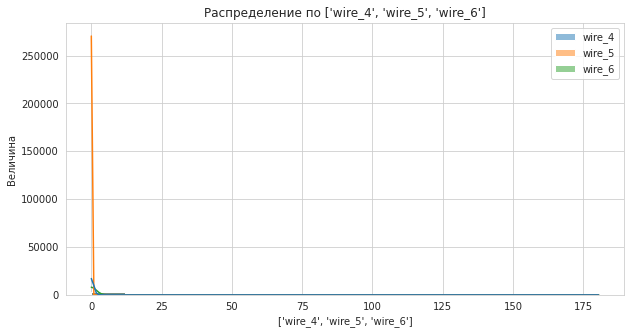

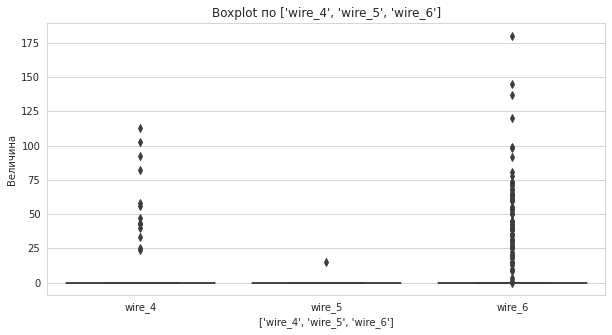

In [36]:
distribution(df_wire, ['wire_4', 'wire_5', 'wire_6'])

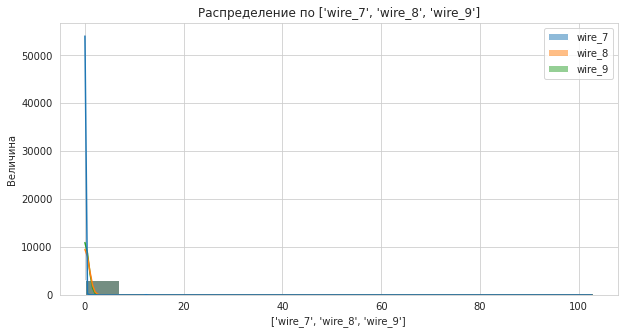

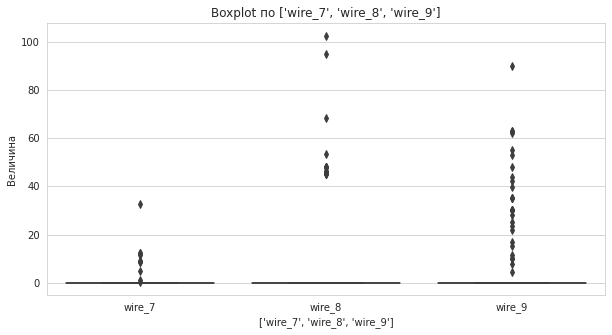

In [37]:
distribution(df_wire, ['wire_7', 'wire_8', 'wire_9'])

<Figure size 720x360 with 0 Axes>

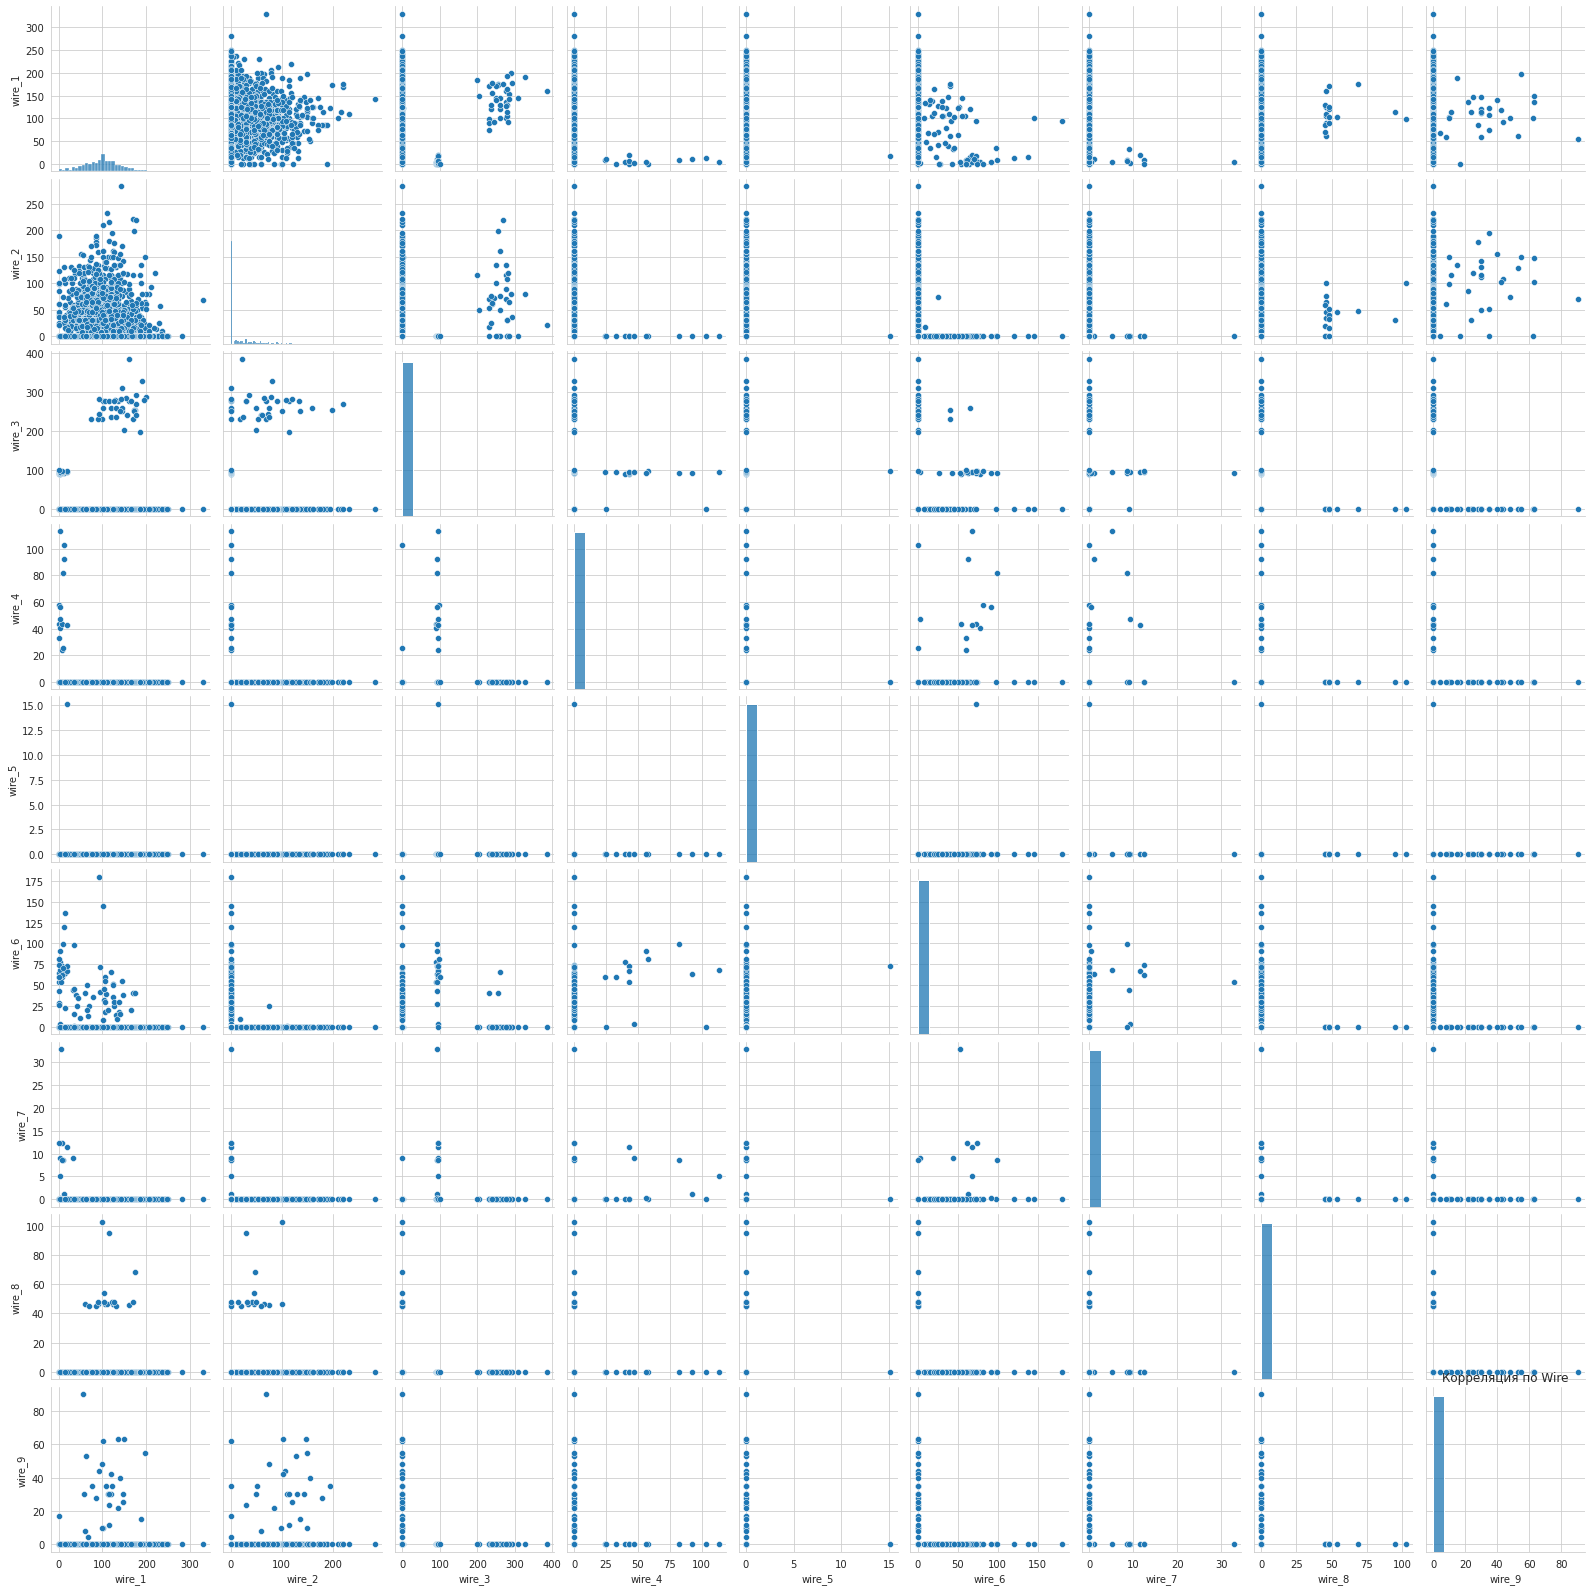

In [38]:
plt.figure(figsize=(10, 5))
sns.pairplot(df_wire[['wire_1', 'wire_2', 'wire_3', 
                      'wire_4', 'wire_5', 'wire_6',
                      'wire_7', 'wire_8', 'wire_9']])
plt.title('Корреляция по Wire')
plt.show()

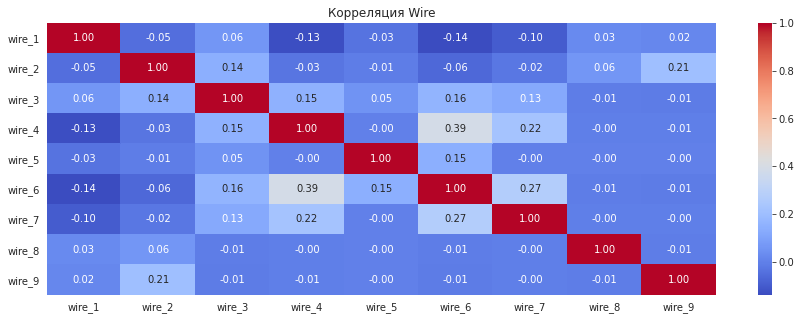

In [39]:
corr_matrix_wire = df_wire[['wire_1', 'wire_2', 'wire_3', 
                       'wire_4', 'wire_5', 'wire_6',
                       'wire_7', 'wire_8', 'wire_9']].corr()

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix_wire, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция Wire')
plt.show()

**Выводы по Wire**

- С каждой итерацией консентрация проволоки немного увеличивается (меньше нулей в каждой последующей итерации)
- Как правило, за одну итерацию добавляют небольшое количество проволоки, лиюо не добавляют вообще
- Наиболее близкие друг у другу значения между 4-5 итерациями. Это может означать, что сначала добавляют небольшое количество проволоки, на 4-6 итерациях чуть больше, и количество снова уменьшается на последующих итерациях. Об этом говорит корреляция

### df_bulk EDA

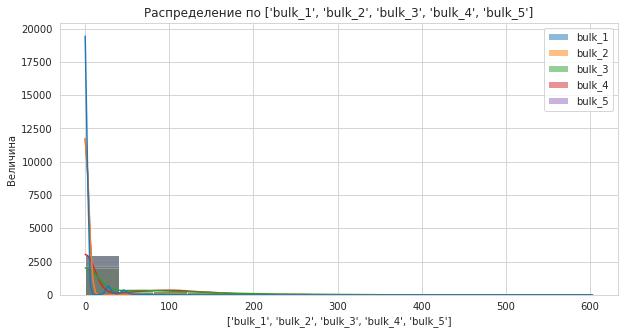

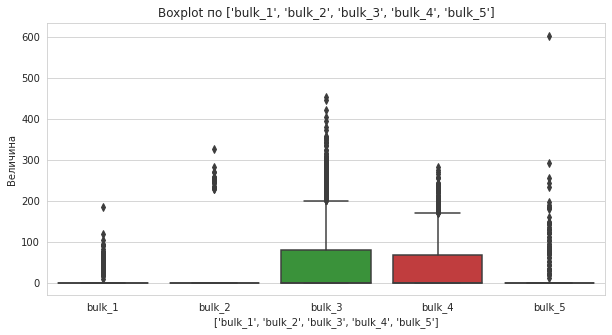

In [40]:
distribution(df_bulk_new, ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5'])

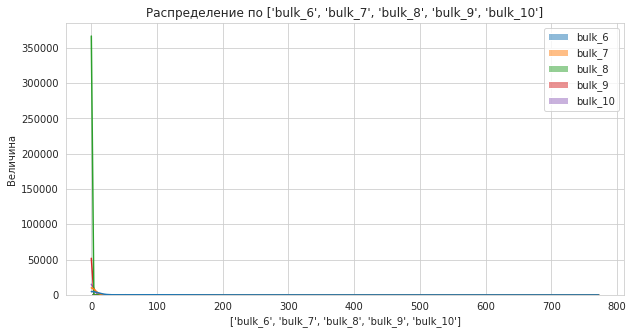

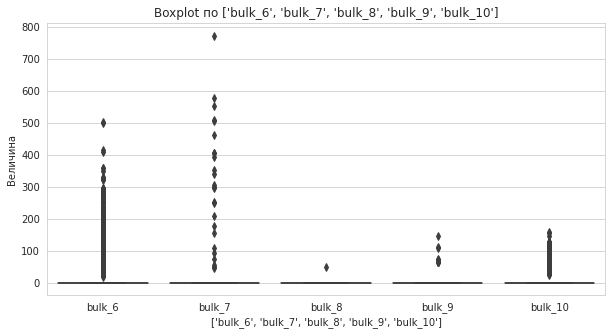

In [41]:
distribution(df_bulk_new, ['bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10'])

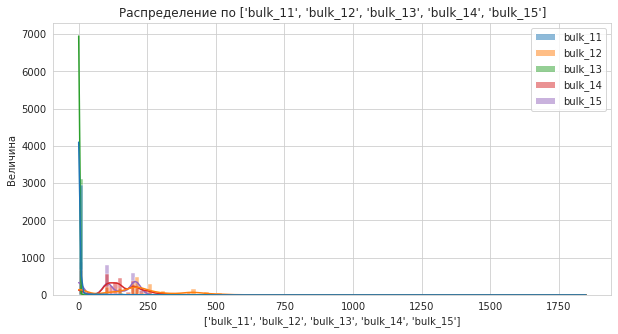

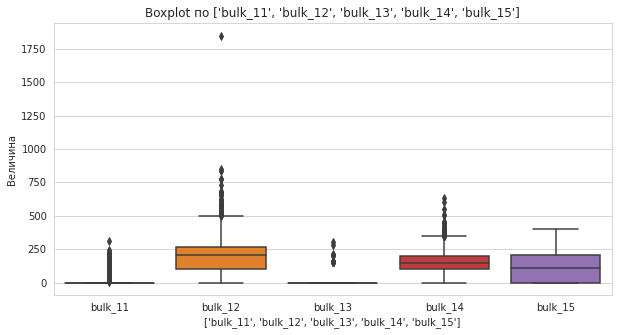

In [42]:
distribution(df_bulk_new, ['bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'])

<Figure size 720x360 with 0 Axes>

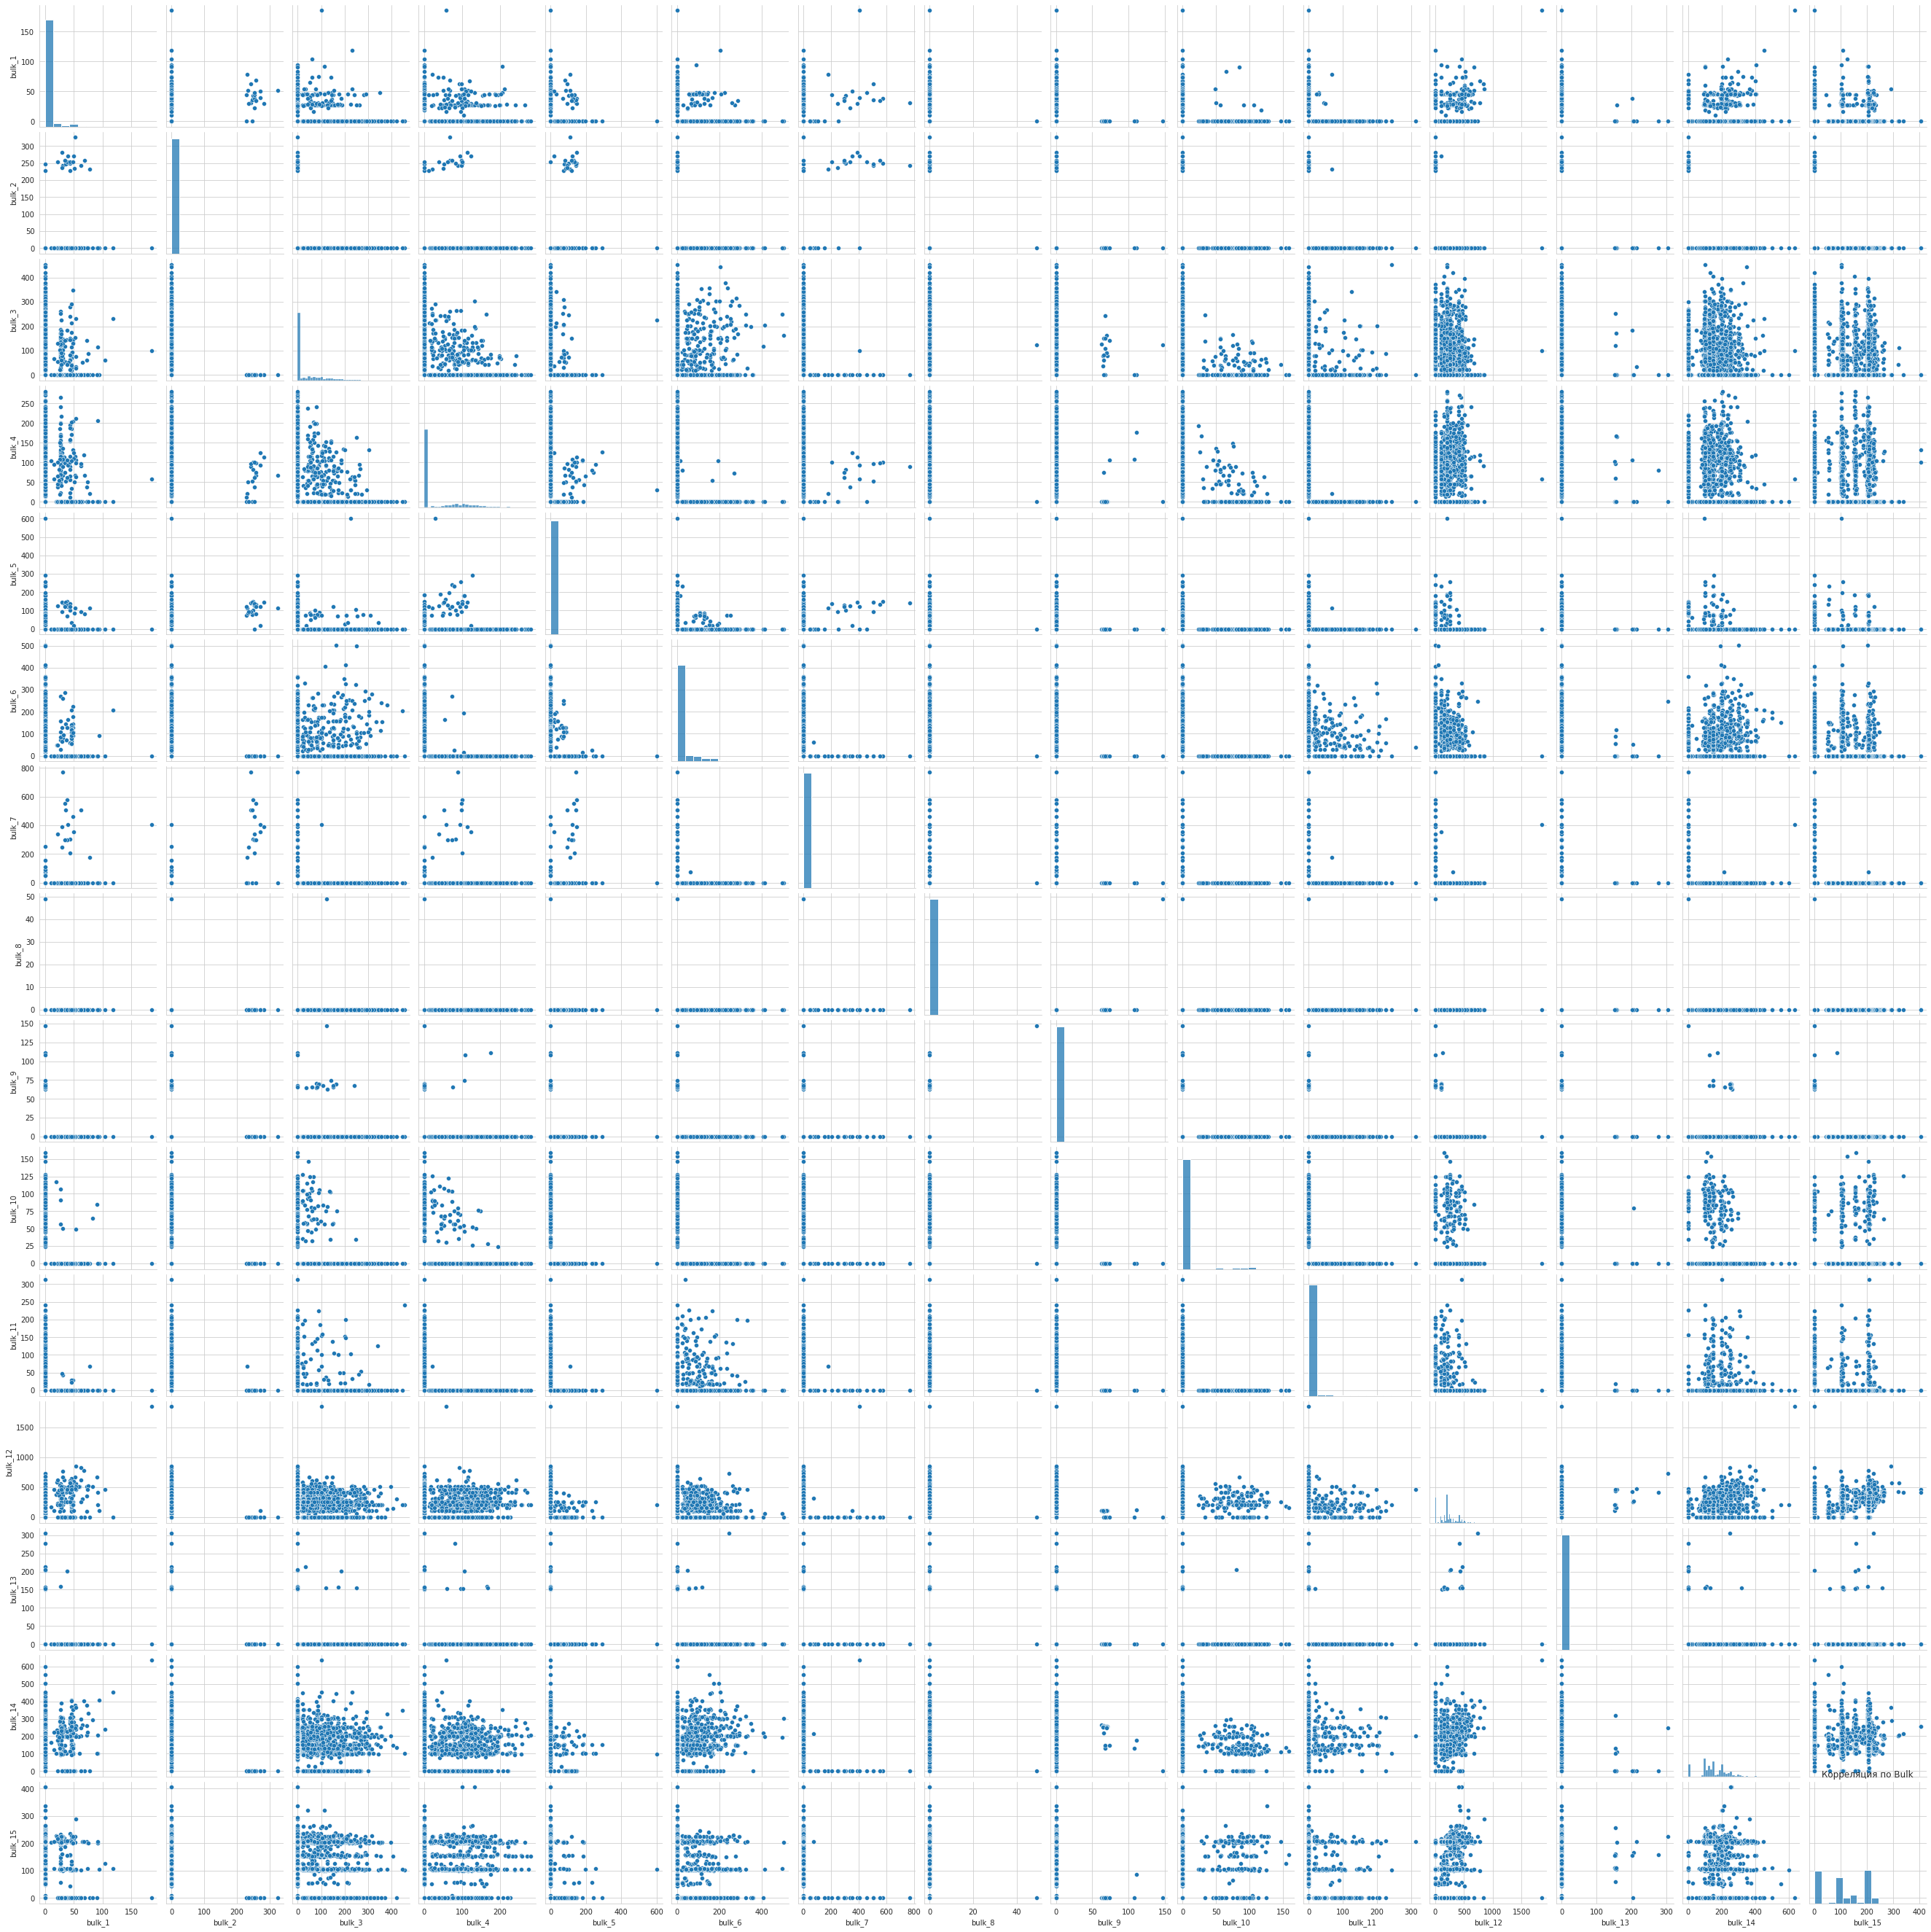

In [43]:
plt.figure(figsize=(10, 5))
sns.pairplot(df_bulk_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 
                          'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                          'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']])
plt.title('Корреляция по Bulk')
plt.show()

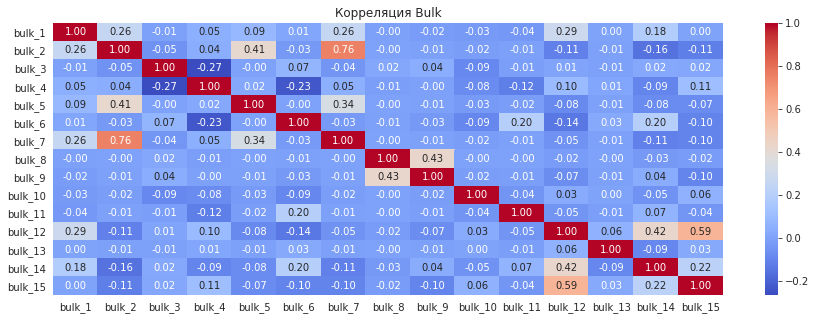

In [44]:
corr_matrix_bulk = df_bulk_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 
                                'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                                'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']].corr()

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix_bulk, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция Bulk')
plt.show()

**Выводы по Bulk**

- На первых двух итерациях, а также с 6 по 11 значения добавлений сыпучих примесей близко к нулю
- Больше всего примесей добавляют на 3, 4, 15, 12 и 14 соответственно
- На матрице корреляции видно, что размер добавления примесей, в разной степени, пропорицонален на 2 и 7 итерации, на 2 и 5, на 8 и 9, на 12 и 15 – между этими парами наблюдается умеренная корреляция 

### df_gas EDA

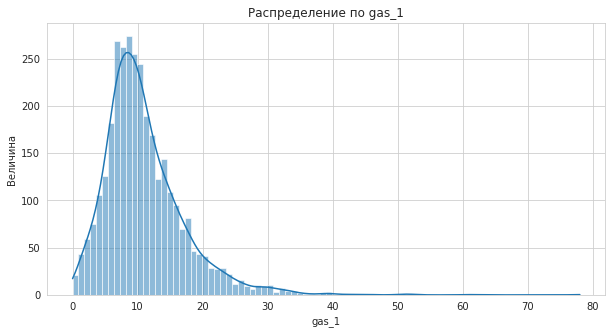

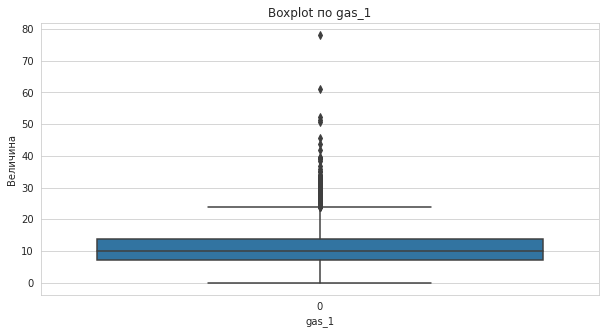

In [45]:
distribution(df_gas, 'gas_1')

**Выводы по Gas**

- В среднем, подаётся 10 у.е. (условных единиц) газа
- Большинство значений сосредоточены в интервале 0-25 у.е., значения больше (30-80) встречаются значительно реже

### df_temp EDA

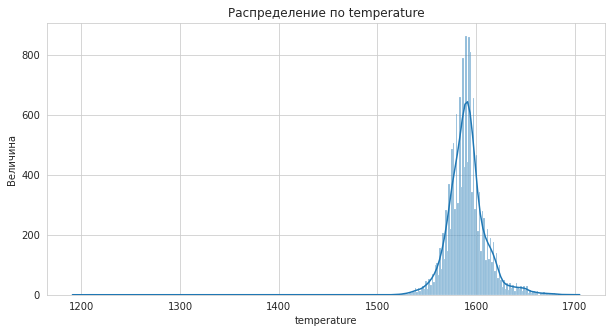

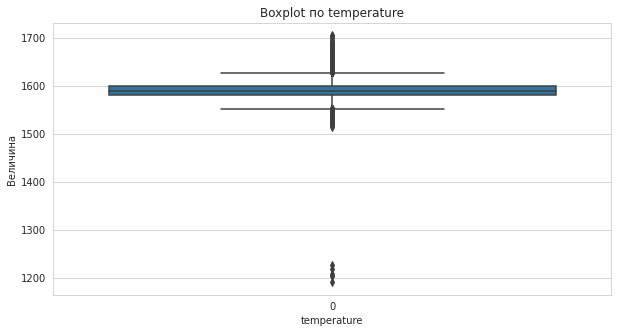

In [46]:
distribution(df_temp, 'temperature')

In [47]:
df_temp = df_temp.loc[df_temp['temperature'] > 1500]

**Выводы по temperature**

- В основном, значения сосредоточены вокруг 1600 градусов
- Есть незначительное количество значений меньше 1300, но это аномалии, которые будут удалены, так как температура плавления начинается с 1500, что также было обговорено с заказчиком
- Без учёта выбросов, распределение температуры можно считать нормальным

**Общий вывод по анализу данных**

- В данных по сыпучим примесям и проволоке имеется множество нулевых значений, что говорит о допустимости их не добавления на некоторых итерациях 
- Как правило, больше всего нулей на первых итерациях, что может говорить о том, что изначально смотрят на плавление без примесей и потом добавляют
- На середине числа итераций количество добавляемых за одну итерацию примесей увеличивается
- Некоторые итерации влияют друг на друга, чем больше примесей добавляется на одной итерации, тем, вероятно, больше может понадобиться на второй.
- При плавлении добавляют 10 условных единиц газа
- При плавлении температура держится в диапазоне 1560-1700 градусов

### Объединение данных

#### Подготовка датасетов

Логично будет объединять данные вокруг таблицы df_temp, потому что в ней содержится информация, из которой будет рассчитываться целевой признак

In [48]:
df_temp = df_temp.groupby('key').agg({
    'measure_time': ['min', 'max'],
    'temperature': ['first', 'last']
}).rename(columns={
    'min': 'time_start',
    'max': 'time_end',
    'first': 'temp_start',
    'last': 'temp_end'
}).reset_index()

In [49]:
df_temp = df_temp.set_index('key').rename(columns={
    'min': 'time_start',
    'max': 'time_end',
    'first': 'temp_start',
    'last': 'temp_end'
})

df_temp.columns = df_temp.columns.droplevel(0)

In [50]:
df_temp['time_full'] = (df_temp['time_end'] - df_temp['time_start']).dt.total_seconds()

In [51]:
df_temp.head()

time_start            time_end  temp_start  temp_end  time_full
key                                                                         
1   2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0    1613.0     1714.0
2   2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0    1602.0     1265.0
3   2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0    1599.0     1753.0
4   2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0    1625.0     1220.0
5   2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0    1602.0     1536.0

In [52]:
df_temp.isna().sum()

time_start    0
time_end      0
temp_start    0
temp_end      0
time_full     0
dtype: int64

In [53]:
# Это данные на удаление (тут 1 замер)
df_t = df_temp.loc[df_temp['time_start'] == df_temp['time_end']]
df_t.head()

time_start            time_end  temp_start  temp_end  time_full
key                                                                          
195  2019-05-11 00:01:36 2019-05-11 00:01:36      1583.0    1583.0        0.0
279  2019-05-14 10:13:01 2019-05-14 10:13:01      1603.0    1603.0        0.0
2500 2019-08-10 14:04:39 2019-08-10 14:04:39      1539.0    1539.0        0.0
2501 2019-08-10 14:41:14 2019-08-10 14:41:14      1587.0    1587.0        0.0
2502 2019-08-10 15:39:39 2019-08-10 15:39:39      1583.0    1583.0        0.0

In [54]:
df_temp = df_temp.loc[df_temp['time_start'] != df_temp['time_end']]

In [55]:
df_temp = df_temp.drop(['time_start', 'time_end'], axis=1)
df_temp.head()

temp_start  temp_end  time_full
key                                 
1        1571.0    1613.0     1714.0
2        1581.0    1602.0     1265.0
3        1596.0    1599.0     1753.0
4        1601.0    1625.0     1220.0
5        1576.0    1602.0     1536.0

В итоге, мы получили данные о начальной и конечной температурах, а также о времени достижения иноговой температуры

In [56]:
df_temp.shape

(2475, 3)

In [57]:
df_arc.head()

key   arc_heating_start  arc_heating_finish  active_power  reactive_power
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691

In [58]:
df_arc = df_arc.groupby('key').agg({
    'arc_heating_start': 'min',
    'arc_heating_finish': 'max',
    'active_power': 'sum',
    'reactive_power': 'sum',
}).rename(columns={
    'arc_heating_start': 'min_start_heating',
    'arc_heating_finish': 'max_end_heating',
    'active_power': 'sum_active_power',
    'reactive_power': 'sum_reactive_power',
})

df_arc.head()

min_start_heating     max_end_heating  sum_active_power  \
key                                                             
1   2019-05-03 11:02:14 2019-05-03 11:28:37          3.036730   
2   2019-05-03 11:34:14 2019-05-03 11:53:18          2.139408   
3   2019-05-03 12:06:54 2019-05-03 12:32:19          4.063641   
4   2019-05-03 12:39:37 2019-05-03 12:57:50          2.706489   
5   2019-05-03 13:11:13 2019-05-03 13:33:55          2.252950   

     sum_reactive_power  
key                      
1              2.142821  
2              1.453357  
3              2.937457  
4              2.056992  
5              1.687991

In [59]:
df_arc['time_arc'] = (df_arc['max_end_heating'] - df_arc['min_start_heating']).dt.total_seconds()
df_arc = df_arc.drop(['max_end_heating', 'min_start_heating'], axis=1)
df_arc.head()

sum_active_power  sum_reactive_power  time_arc
key                                                
1            3.036730            2.142821    1583.0
2            2.139408            1.453357    1144.0
3            4.063641            2.937457    1525.0
4            2.706489            2.056992    1093.0
5            2.252950            1.687991    1362.0

Аналогично датасету с температурой, мы вычислили время и итоговую мощность

#### Объединение датасетов

In [60]:
df_bulk = df_bulk_new.set_index('key')
df_gas = df_gas.set_index('key')
df_wire = df_wire.set_index('key')

df = df_temp.join([df_arc, df_gas, df_bulk, df_wire], how='inner')

In [61]:
df.head()

temp_start  temp_end  time_full  sum_active_power  sum_reactive_power  \
key                                                                          
1        1571.0    1613.0     1714.0          3.036730            2.142821   
2        1581.0    1602.0     1265.0          2.139408            1.453357   
3        1596.0    1599.0     1753.0          4.063641            2.937457   
4        1601.0    1625.0     1220.0          2.706489            2.056992   
5        1576.0    1602.0     1536.0          2.252950            1.687991   

     time_arc      gas_1  bulk_1  bulk_2  bulk_3  ...  bulk_15     wire_1  \
key                                               ...                       
1      1583.0  29.749986     0.0     0.0     0.0  ...    154.0  60.059998   
2      1144.0  12.555561     0.0     0.0     0.0  ...    154.0  96.052315   
3      1525.0  28.554793     0.0     0.0     0.0  ...    153.0  91.160157   
4      1093.0  18.841219     0.0     0.0     0.0  ...    154.0  89.063515   
5      1362.0   5.413692     0.0     0.0     0.0  ...    152.0  89.238236   

      wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9  
key                                                                   
1    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
5    9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 31 columns]

Дополнительным заданием было вычисление полной мощности, как ещё одного признака. С учётом удаления большого числа признаков дальше, стоит попробовать рассмотреть данное поле

In [62]:
df['full_power'] = df.apply(lambda row: 
                            math.sqrt(row['sum_active_power']**2 + row['sum_reactive_power']**2), 
                            axis=1)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp_start          2329 non-null   float64
 1   temp_end            2329 non-null   float64
 2   time_full           2329 non-null   float64
 3   sum_active_power    2329 non-null   float64
 4   sum_reactive_power  2329 non-null   float64
 5   time_arc            2329 non-null   float64
 6   gas_1               2329 non-null   float64
 7   bulk_1              2329 non-null   float64
 8   bulk_2              2329 non-null   float64
 9   bulk_3              2329 non-null   float64
 10  bulk_4              2329 non-null   float64
 11  bulk_5              2329 non-null   float64
 12  bulk_6              2329 non-null   float64
 13  bulk_7              2329 non-null   float64
 14  bulk_8              2329 non-null   float64
 15  bulk_9              2329 non-null   float64
 16  bulk_1

In [64]:
df.isna().sum()

temp_start            0
temp_end              0
time_full             0
sum_active_power      0
sum_reactive_power    0
time_arc              0
gas_1                 0
bulk_1                0
bulk_2                0
bulk_3                0
bulk_4                0
bulk_5                0
bulk_6                0
bulk_7                0
bulk_8                0
bulk_9                0
bulk_10               0
bulk_11               0
bulk_12               0
bulk_13               0
bulk_14               0
bulk_15               0
wire_1                0
wire_2                0
wire_3                0
wire_4                0
wire_5                0
wire_6                0
wire_7                0
wire_8                0
wire_9                0
full_power            0
dtype: int64

In [65]:
df.shape

(2329, 32)

In [66]:
df.index.nunique()

2329

In [67]:
df.idxmax

<bound method DataFrame.idxmax of       temp_start  temp_end  time_full  sum_active_power  sum_reactive_power  \
key                                                                           
1         1571.0    1613.0     1714.0          3.036730            2.142821   
2         1581.0    1602.0     1265.0          2.139408            1.453357   
3         1596.0    1599.0     1753.0          4.063641            2.937457   
4         1601.0    1625.0     1220.0          2.706489            2.056992   
5         1576.0    1602.0     1536.0          2.252950            1.687991   
...          ...       ...        ...               ...                 ...   
2495      1570.0    1591.0     1380.0          3.168133            2.210936   
2496      1554.0    1591.0     1705.0          4.174918            2.872031   
2497      1571.0    1589.0      962.0          3.605239            2.452092   
2498      1591.0    1594.0     1520.0          3.202310            2.239820   
2499      1569.0  

По требованию заказчика, из таблицы удалены ключи больше 1500, а также те ключи, где только 1 замер температуры

По требованию заказчика, в итоговом датасете нужно вывести таблицу корреляции признаков

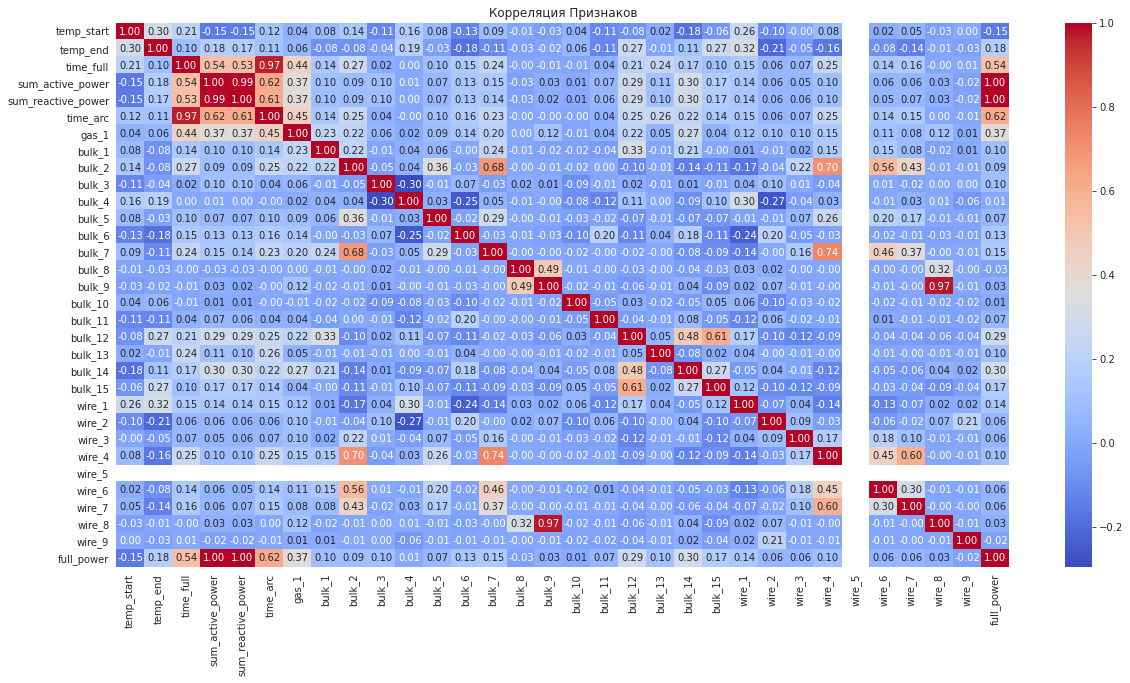

In [68]:
corr_matrix_df = df.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция Признаков')
plt.show()

In [69]:
df.columns

Index(['temp_start', 'temp_end', 'time_full', 'sum_active_power',
       'sum_reactive_power', 'time_arc', 'gas_1', 'bulk_1', 'bulk_2', 'bulk_3',
       'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8',
       'wire_9', 'full_power'],
      dtype='object')

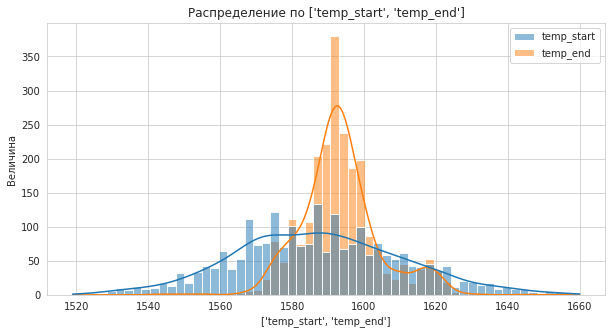

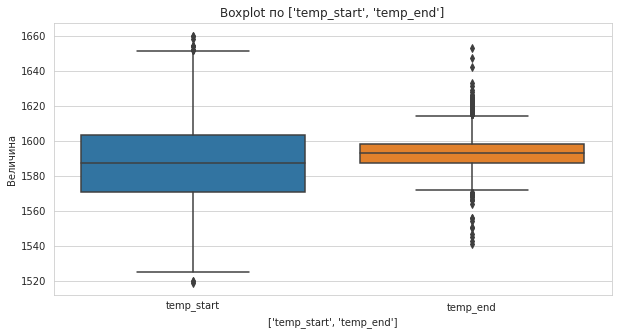

In [70]:
distribution(df, ['temp_start', 'temp_end'])

**Вывод**

- Мы объединили данные в отдельный датасет
- Размер итогового датасета: 3022 на 30
- Была посчитана целевая переменная
- Была рассмотрена матрица корреляции, на основании которой было удалено поле time_arc
- Были рассмотрены распределения температуры и времени: имеется некоторое количество выбросов, с которыми мы будем работать в дальнейшем

## Подготовка данных к обучению модели

In [71]:
features = df.drop('temp_end', axis=1)

target = df['temp_end']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=RS)

X_train.shape

(1746, 31)

In [73]:
X_test.shape

(583, 31)

In [74]:
X_train.columns

Index(['temp_start', 'time_full', 'sum_active_power', 'sum_reactive_power',
       'time_arc', 'gas_1', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
       'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'full_power'],
      dtype='object')

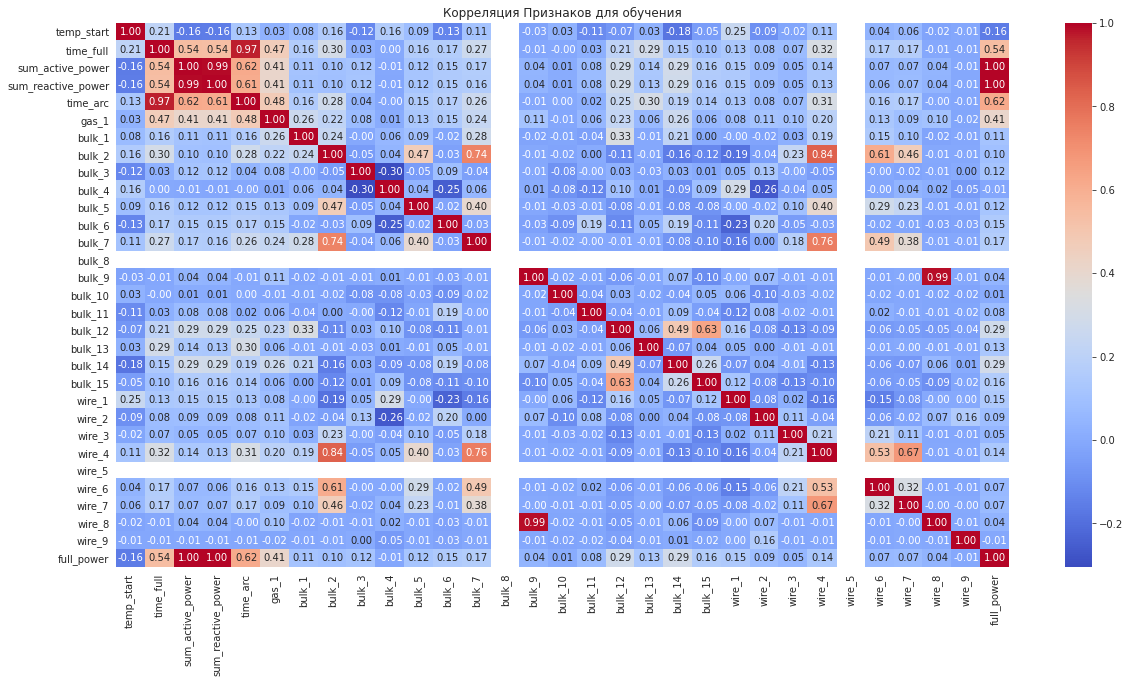

In [75]:
corr_matrix_X = X_train.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix_X, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция Признаков для обучения')
plt.show()

На основе матрицы корреляции признаков, мы выявили ряд признаков, подлежащих удалению. 
Нем не менее, удаление некоторых признаков ухудшало модель, поэтому не все признаки, в итоге, были удалены

Признаки на удаление: ['bulk_2', 'wire_4', 'wire_7', 'bulk_9', 'wire_8', 'bulk_8', 'wire_5', 
          'sum_reactive_power', 'sum_active_power']
          
Удаляю их тут, а не на df, потому что подбирал некоторые эмпирически, и не нужно было каждый раз перезапускать ядро: можно было начать с df

In [76]:
cols_r = ['bulk_2', 'wire_4', 'wire_7', 'bulk_9', 'wire_8', 'bulk_8', 'wire_5', 
          'sum_reactive_power', 'sum_active_power']

X_train = X_train.drop(cols_r, axis=1)
X_test = X_test.drop(cols_r, axis=1)

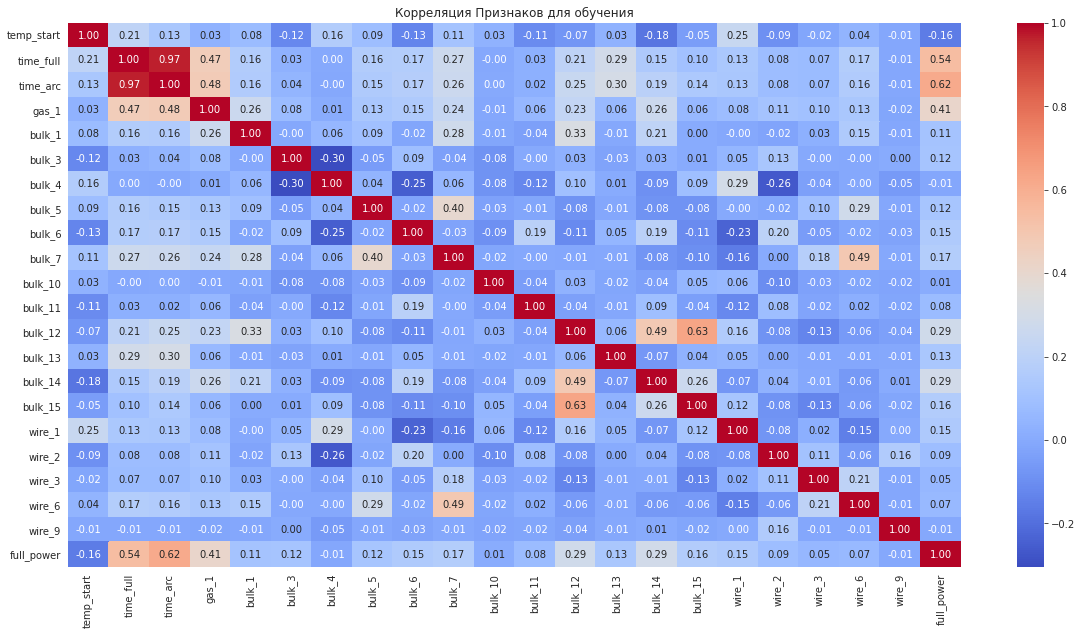

In [77]:
corr_matrix_X = X_train.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix_X, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция Признаков для обучения')
plt.show()

In [78]:
X_train = X_train.drop('time_arc', axis=1)
X_test = X_test.drop('time_arc', axis=1)

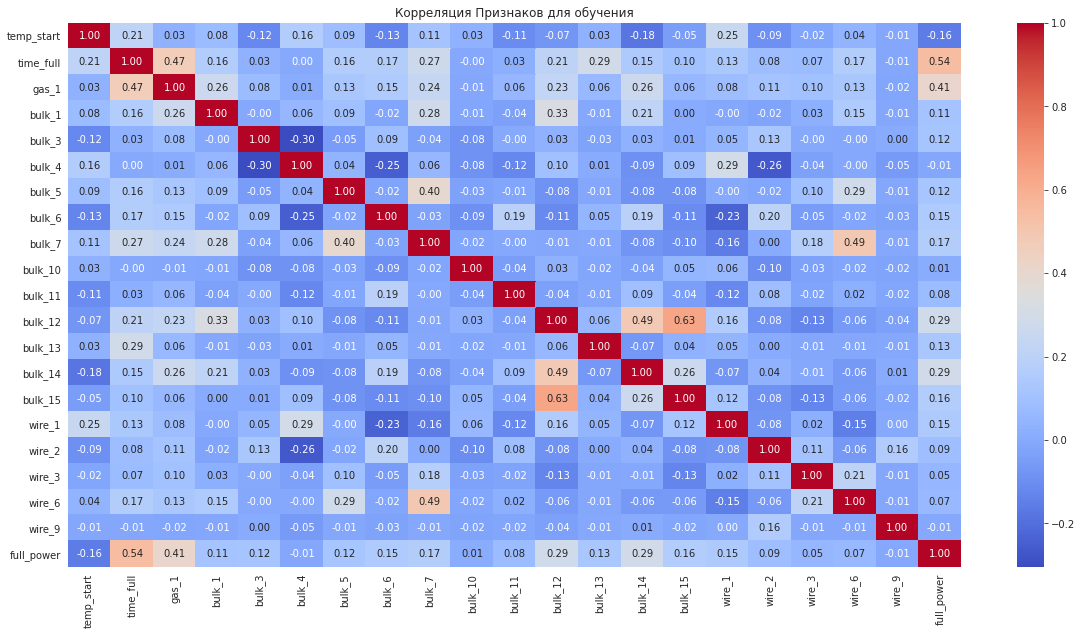

In [79]:
corr_matrix_X = X_train.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix_X, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция Признаков для обучения')
plt.show()

In [80]:
data_names = [y_train, y_test, X_train['temp_start'], X_test['temp_start']]

for i in data_names:
    print(i.min())

1541.0
1554.0
1520.0
1519.0


- В тестовой выборке более 1700 строк, что соответствует ТЗ
- Температур ниже 1500 гредусов нет

In [81]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
X_train_scaled[0]

array([-0.03900774, -0.19934342, -0.45165868, -0.26619524, -0.63690508,
       -0.64235858, -0.13363475, -0.4004594 , -0.07034928, -0.23394758,
       -0.18845284, -0.01391375, -0.07633247, -0.18194547, -0.21619407,
       -0.00980358, -0.52323531, -0.12365664, -0.11639532, -0.08527874,
       -1.30766915])

In [83]:
X_test_scaled[0]

array([-1.60810976, -0.56679116, -0.52463446, -0.26619524,  0.06069245,
       -0.64235858, -0.13363475, -0.4004594 , -0.07034928, -0.23394758,
       -0.18845284, -1.31966877, -0.07633247, -1.87644927, -1.42780065,
       -0.7781668 ,  2.39221103, -0.12365664, -0.11639532, -0.08527874,
        1.12061818])

## Выбор моделей

### Linear Regression

In [84]:
model_reg = LinearRegression()
model_reg.fit(X_train_scaled, y_train)
cv_reg = cross_val_score(model_reg,
                         X_train_scaled,
                         y_train,
                         cv=5,
                         scoring='neg_mean_absolute_error')
reg_mae = -np.mean(cv_reg)
reg_mae

7.237834966133074

### Lasso

In [85]:
parameters_lasso = {
    'alpha': [0.5, 1, 3, 5],
    'max_iter': [50, 100, 300, 500, 700, 900, 1000],
    'selection': ['cyclic', 'random']
}

model_lasso = Lasso(random_state=RS)
search_lasso = GridSearchCV(model_lasso, 
                            parameters_lasso, 
                            cv=5, 
                            scoring='neg_mean_absolute_error')
search_lasso.fit(X_train_scaled, y_train)

params_best_lasso = search_lasso.best_params_
mae_best_lasso = -search_lasso.best_score_

print(params_best_lasso)
print(mae_best_lasso)

{'alpha': 0.5, 'max_iter': 50, 'selection': 'random'}
7.158882057524451


### Ridge

In [86]:
parameters_ridge = {
    'alpha' : range(1000, 20000, 1000),
    'max_iter': [50, 100, 300, 500, 700, 900, 1000]
}

model_ridge = Ridge(random_state=RS)
search_ridge = GridSearchCV(model_ridge, 
                            parameters_ridge,
                            cv=5,
                            scoring='neg_mean_absolute_error')
search_ridge.fit(X_train_scaled, y_train)

params_best_ridge = search_ridge.best_params_
mae_best_ridge = -search_ridge.best_score_

print(params_best_ridge)
print(mae_best_ridge)

{'alpha': 1000, 'max_iter': 50}
7.172440673626843


### Decision Tree

In [87]:
parameters_tree = {
    'max_depth': range(1, 40, 2),
    'min_samples_leaf': range(1, 40, 2)
}

model_tree = DecisionTreeRegressor(random_state=RS)
search_tree = GridSearchCV(model_tree,
                           parameters_tree,
                           cv=5,
                           scoring='neg_mean_absolute_error')
search_tree.fit(X_train_scaled, y_train)

params_best_tree = search_tree.best_params_
mae_best_tree = -search_tree.best_score_

print(params_best_tree)
print(mae_best_tree)

{'max_depth': 7, 'min_samples_leaf': 19}
7.465369832679919


### Random Forest

In [88]:
parameters_forest = {
    'max_depth': range(1, 30, 2),
    'n_estimators': range(1, 30, 2)
}

model_forest = RandomForestRegressor(random_state=RS)
search_forest = GridSearchCV(model_forest,
                             parameters_forest,
                             cv=5,
                             scoring='neg_mean_absolute_error')
search_forest.fit(X_train_scaled, y_train)

params_best_forest = search_forest.best_params_
mae_best_forest = -search_forest.best_score_

print(params_best_forest)
print(mae_best_forest)

{'max_depth': 7, 'n_estimators': 27}
6.980822208154697


### Catboost Regressor

In [89]:
parameters_catboost = {
    'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2]
}

model_catboost = CatBoostRegressor(random_state=RS, iterations=400)
search_catboost = GridSearchCV(model_catboost,
                               parameters_catboost,
                               cv=5,
                               scoring='neg_mean_absolute_error')
search_catboost.fit(X_train_scaled, y_train)

params_best_catboost = search_catboost.best_params_
mae_best_catboost = -search_catboost.best_score_

print(params_best_catboost)
print(mae_best_catboost)

0:	learn: 11.0460169	total: 51.4ms	remaining: 20.5s
1:	learn: 11.0212570	total: 54.8ms	remaining: 10.9s
2:	learn: 11.0018393	total: 57.9ms	remaining: 7.67s
3:	learn: 10.9788292	total: 60.8ms	remaining: 6.02s
4:	learn: 10.9562943	total: 63.7ms	remaining: 5.04s
5:	learn: 10.9358515	total: 66.6ms	remaining: 4.38s
6:	learn: 10.9132710	total: 69.5ms	remaining: 3.9s
7:	learn: 10.8900257	total: 72.3ms	remaining: 3.54s
8:	learn: 10.8706537	total: 75.4ms	remaining: 3.27s
9:	learn: 10.8479642	total: 78.4ms	remaining: 3.06s
10:	learn: 10.8295613	total: 81.1ms	remaining: 2.87s
11:	learn: 10.8131344	total: 84ms	remaining: 2.72s
12:	learn: 10.7938133	total: 86.8ms	remaining: 2.58s
13:	learn: 10.7753746	total: 89.6ms	remaining: 2.47s
14:	learn: 10.7558196	total: 92.5ms	remaining: 2.38s
15:	learn: 10.7392362	total: 95.5ms	remaining: 2.29s
16:	learn: 10.7181855	total: 98.5ms	remaining: 2.22s
17:	learn: 10.6986571	total: 101ms	remaining: 2.15s
18:	learn: 10.6793905	total: 104ms	remaining: 2.1s
19:	learn

**Вывод**

Целевая метрика должна быть меньше 6.8
С этой задачей справилась модель CatBoostRegressor() с параметрами:
- iterations=400
- learning_rate=0.04

Ниже приведена итоговая таблица по моделм и их метрикам

In [90]:
models = ['Linear Regression', 'Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'CatBoost']
metrics = [reg_mae, mae_best_lasso, mae_best_ridge, mae_best_tree, mae_best_forest, mae_best_catboost]

result = pd.DataFrame({
    'models':models,
    'mae':metrics
})

result

models       mae
0  Linear Regression  7.237835
1              Lasso  7.158882
2              Ridge  7.172441
3      Decision Tree  7.465370
4      Random Forest  6.980822
5           CatBoost  6.763460

## Тестирование модели

In [91]:
base_model = DummyRegressor(strategy='mean')
base_model.fit(X_train_scaled, y_train)
base_y_pred = base_model.predict(X_test_scaled)

mae_base = mean_absolute_error(y_test, base_y_pred)
mae_base

8.155685428492273

In [92]:
model_test = CatBoostRegressor(random_state=RS, iterations=400, learning_rate=0.04)
model_test.fit(X_train_scaled, y_train)
y_pred = model_test.predict(X_test_scaled)

mae_final = mean_absolute_error(y_test, y_pred)
r2_final = r2_score(y_test, y_pred)

0:	learn: 11.1209191	total: 3.34ms	remaining: 1.33s
1:	learn: 11.0285222	total: 6.57ms	remaining: 1.31s
2:	learn: 10.9298257	total: 9.85ms	remaining: 1.3s
3:	learn: 10.8486719	total: 12.8ms	remaining: 1.26s
4:	learn: 10.7762113	total: 15.6ms	remaining: 1.23s
5:	learn: 10.7083391	total: 19ms	remaining: 1.25s
6:	learn: 10.6334739	total: 21.7ms	remaining: 1.22s
7:	learn: 10.5649158	total: 24.6ms	remaining: 1.2s
8:	learn: 10.4965927	total: 27.6ms	remaining: 1.2s
9:	learn: 10.4233934	total: 31.2ms	remaining: 1.21s
10:	learn: 10.3633623	total: 34.2ms	remaining: 1.21s
11:	learn: 10.2980861	total: 37.3ms	remaining: 1.21s
12:	learn: 10.2394845	total: 40.4ms	remaining: 1.2s
13:	learn: 10.1750752	total: 43.4ms	remaining: 1.2s
14:	learn: 10.1294653	total: 46.3ms	remaining: 1.19s
15:	learn: 10.0763159	total: 49.6ms	remaining: 1.19s
16:	learn: 10.0236872	total: 52.9ms	remaining: 1.19s
17:	learn: 9.9908978	total: 56.2ms	remaining: 1.19s
18:	learn: 9.9429199	total: 59.3ms	remaining: 1.19s
19:	learn: 9

In [93]:
print(mae_final)
print(r2_final)

6.771063650679114
0.33809447602834075


**Вывод**

- Метрика итоговой модели лучше, чем метрика константной модели
- Итоговая модель протестирована и соответствует требованиям заказчика, а также не демонстрирует признаков переобучения

## Общий вывод

**Перед общив выводом представим диаграму важности признаков**

In [94]:
explainer_catboost = shap.Explainer(model_test, dependence='independent')
shap_values_catboost = explainer_catboost.shap_values(X_test_scaled)

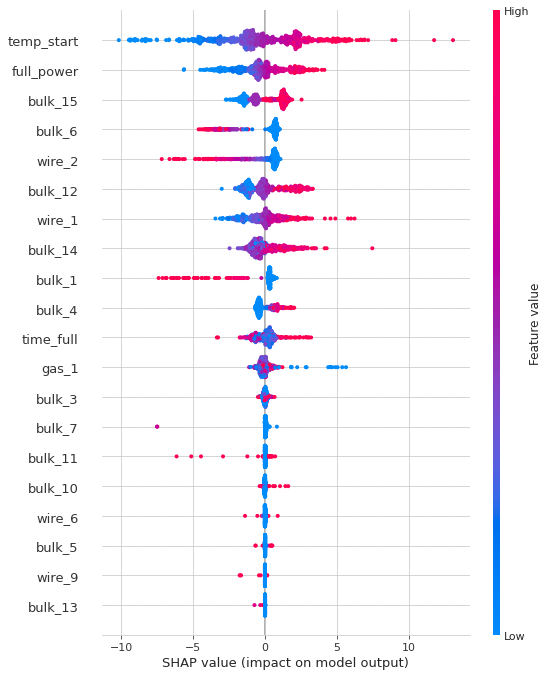

In [95]:
shap.summary_plot(shap_values_catboost, X_test_scaled, feature_names=X_train.columns)

### Выводы по значимости признаков

- Наиболее важным признаком для модели стала начальаня температура: чем выше начальная температура, тем выше будет финальная
- Вторым важным признаком стала 15 итерация добавления сыпучих смесей
- Третьим признаком стала общая мощность: чем выше мощность, тем выше будет температура, однако низкие показатели мощности будут очень сильно понижать температуру
- 12, 14 итерации добавления сыпучих смесей не сильно понижает температуру, если ей принебрегать, но значительно повышает, если она есть
- с 1, 6 итерациями добавления сыпучих смесей и 2 итерацией добавления проволоки ситуация обстоит противоположная предыдущей (тут настоятельно не рекомендуется добавлять примеси)


### Общий вывод

- Были получены и проанализированы данные со сталелитейного производства
- Всего было изучено 7 таблиц, содержащих информацию о температурах, времени замерения, времени нагрева и нагреве, доабвлении сыпучих и металлических примесей
- В ходе исследовательского анализа было установлено:

    Выводы по arc
    
    - Медианная мощность 0.6 у.о. Размах мощности от 0.2 до 1.5


    Выводы по temperature
    
    - В основном, значения сосредоточены вокруг 1600 градусов
    - Есть незначительное количество значений меньше 1300, но это аномалии, которые будут удалены, так как температура плавления начинается с 1500, что также было обговорено с заказчиком
    - Без учёта выбросов, распределение температуры можно считать нормальным
    - Общий вывод по анализу данных
    - В данных по сыпучим примесям и проволоке имеется множество нулевых значений, что говорит о допустимости их не добавления на некоторых итерациях
    - Как правило, больше всего нулей на первых итерациях, что может говорить о том, что изначально смотрят на плавление без примесей и потом добавляют
    - На середине числа итераций количество добавляемых за одну итерацию примесей увеличивается
    - Некоторые итерации влияют друг на друга, чем больше примесей добавляется на одной итерации, тем, вероятно, больше может понадобиться на второй.
    - При плавлении добавляют 10 условных единиц газа
    - При плавлении температура держится в диапазоне 1560-1700 градусов
    
    
    Выводы по Wire
    
    - С каждой итерацией консентрация проволоки немного увеличивается (меньше нулей в каждой последующей итерации)
    - Как правило, за одну итерацию добавляют небольшое количество проволоки, лиюо не добавляют вообще
    - Наиболее близкие друг у другу значения между 4-5 итерациями. Это может означать, что сначала добавляют небольшое количество проволоки, на 4-6 итерациях чуть больше, и количество снова уменьшается на последующих итерациях. Об этом говорит корреляция


    Выводы по Bulk
    
    - На первых двух итерациях, а также с 6 по 11 значения добавлений сыпучих примесей близко к нулю
    - Больше всего примесей добавляют на 3, 4, 15, 12 и 14 соответственно
    - На матрице корреляции видно, что размер добавления примесей, в разной степени, пропорицонален на 2 и 7 итерации, на 2 и 5, на 8 и 9, на 12 и 15 – между этими парами наблюдается умеренная корреляция
    
    
    Выводы по Gas
    
    - В среднем, подаётся 10 у.е. (условных единиц) газа
    - Большинство значений сосредоточены в интервале 0-25 у.е., значения больше (30-80) встречаются значительно реже



- После изучения данных, таблицы были объединены в отдельный датасет с появлением новых признаков
- Новые признаки: начальаня температура, финальная температура(целевой признак), полная мощность, время нагрева, время нагрева дугой
- Из данных были удалены значения температуры ниже 1500 градусов, так как они ниже температуры плавления стали
- Были удалены ключи выше 2500 по требованию заказчика

### Выводы по Машинному обучению

- На подготовленном датасете мы обучили 6 моделей:

    - Linear Regression	7.747902
    - Lasso	7.199452
    - Ridge	7.230310
    - Decision Tree	7.527633
    - Random Forest	7.030797
    - CatBoost	6.726887
    
- Приемлемую для заказчика метрику показала модель CatBoost
- На тестовой выборке модель также показала приемлемую метрику, не показав признаки переобучения

### Данные по итоговой модели

- Название модели: CatBoostRegressor()

- **Итоговая метрика: MAE = 6.771063650679114**
- Параметры:
    - Число итераций (iterations): 400
    - Randon_state: 111223
    - Величина шага (learning_rate): 0.04

### Рекомендации для бизнеса

- Исходя из исследовательского анализа данных, обратить внимание на добавление сыпучих материалов, так как объёмы добавляемого сырья влияют на объёмы его добавления на последующих итерациях
- Наибольшими по влиянию технчиескими показателями стали начальная температура и полная мощность, поэтому стоит обращать внимание на них. К примеру, стараться держать температуру повыше
- Время нагревания аркой лучше сократить – это возможно сделать с повышением начальной температуры
- Обратить внимание на пункт 6.1